In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
traffic = pd.read_excel("dataset/raw/traffic_data_2013-23.xlsx")
weather = pd.read_excel("dataset/raw/weather_data_2013-23.xlsx")

print(traffic.shape, weather.shape)

(290705, 5) (86184, 8)


### Traffic EDA

In [3]:
traffic.head()

,Site Name,Report Date,Time Period Ending,Avg mph,Total Volume
0,7004/1,2013-06-01T00:00:00,00:59:00,NaN,69.0
1,7004/1,2013-06-01T00:00:00,01:59:00,NaN,33.0
2,7004/1,2013-06-01T00:00:00,02:59:00,NaN,23.0
3,7004/1,2013-06-01T00:00:00,03:59:00,NaN,24.0
4,7004/1,2013-06-01T00:00:00,04:59:00,NaN,26.0


In [4]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290705 entries, 0 to 290704
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Site Name           290705 non-null  object 
 1   Report Date         290705 non-null  object 
 2   Time Period Ending  290705 non-null  object 
 3   Avg mph             255650 non-null  float64
 4   Total Volume        271224 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.1+ MB


In [5]:
traffic.isnull().mean()*100

Site Name              0.000000
Report Date            0.000000
Time Period Ending     0.000000
Avg mph               12.058616
Total Volume           6.701295
dtype: float64

In [6]:
traffic['Date'] = pd.to_datetime(traffic['Report Date'])
traffic['Hour'] = pd.to_timedelta(traffic['Time Period Ending'].str.slice(0, 2) + ':00:00')
traffic['Datetime'] = traffic['Date'] + traffic['Hour']

In [7]:
traffic.drop(['Site Name','Report Date','Time Period Ending','Avg mph','Date','Hour'], axis=1, inplace=True)

In [8]:
agg_traffic = traffic.groupby('Datetime')['Total Volume'].sum().reset_index()

In [9]:
agg_traffic.head()

,Datetime,Total Volume
0,2013-06-01 00:00:00,69.0
1,2013-06-01 01:00:00,33.0
2,2013-06-01 02:00:00,23.0
3,2013-06-01 03:00:00,24.0
4,2013-06-01 04:00:00,26.0


In [10]:
agg_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84349 entries, 0 to 84348
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      84349 non-null  datetime64[ns]
 1   Total Volume  84349 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


In [11]:
agg_traffic = agg_traffic.set_index('Datetime')
date_range = pd.date_range(start=agg_traffic.index.min(), end=agg_traffic.index.max(), freq='H')
agg_traffic = agg_traffic.reindex(date_range, fill_value=np.nan)
agg_traffic.index.names = ['Datetime']

In [12]:
agg_traffic.isnull().sum()

Total Volume    1836
dtype: int64

In [13]:
agg_traffic[agg_traffic['Total Volume'].isnull()]

,Total Volume
Datetime,
2013-07-01 01:00:00,NaN
2013-07-01 02:00:00,NaN
2013-07-01 03:00:00,NaN
2013-07-01 04:00:00,NaN
2013-07-01 05:00:00,NaN
...,...
2021-05-24 22:00:00,NaN
2021-05-24 23:00:00,NaN
2021-05-25 00:00:00,NaN


<AxesSubplot:title={'center':'Distribution of Traffic'}, ylabel='Frequency'>

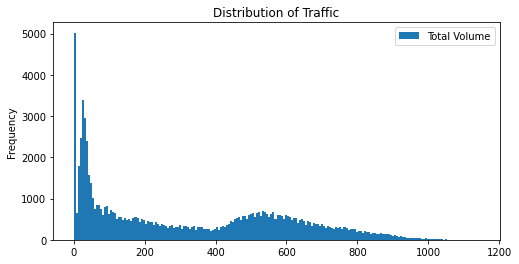

In [14]:
agg_traffic.plot.hist(figsize=(8,4), bins=200, title="Distribution of Traffic")

<AxesSubplot:title={'center':'Road Traffic 2013-2023'}, xlabel='Datetime'>

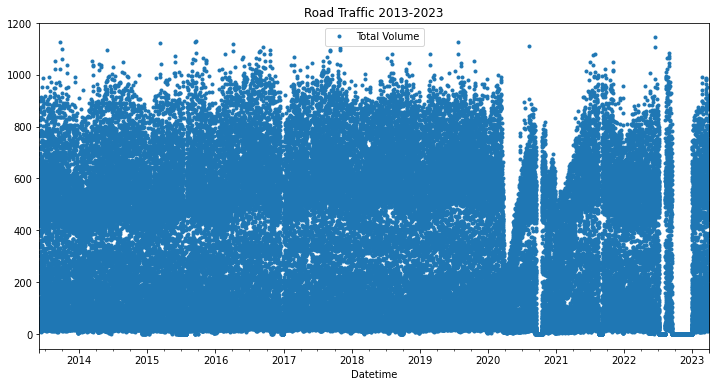

In [15]:
agg_traffic.plot(style='.', figsize=(12,6),  title="Road Traffic 2013-2023")

<AxesSubplot:title={'center':'Seasonality on Daily Basis'}, xlabel='Datetime'>

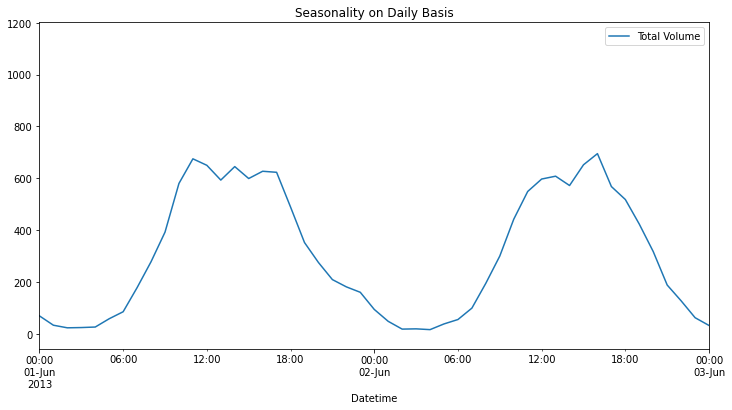

In [16]:
agg_traffic.plot(xlim=['2013-06-01 00:00:00','2013-06-03 00:00:00'], figsize=(12,6), title="Seasonality on Daily Basis")

<AxesSubplot:title={'center':'Seasonality on Weekly Basis'}, xlabel='Datetime'>

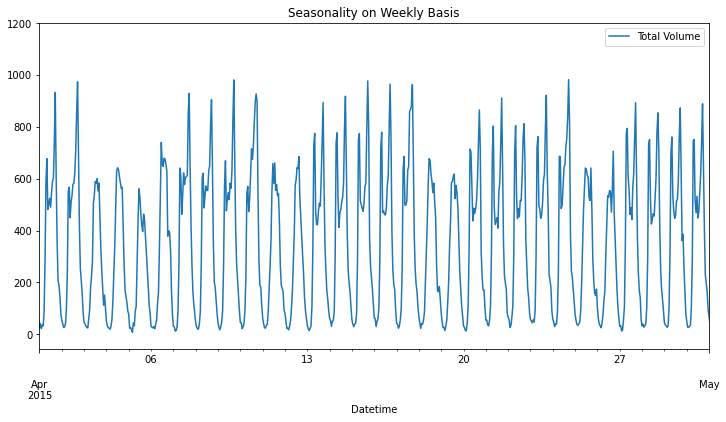

In [17]:
agg_traffic.plot(xlim=['2015-04-01 00:00:00','2015-05-01 00:00:00'], figsize=(12,6), title="Seasonality on Weekly Basis")

<AxesSubplot:title={'center':'Seasonality on Monthly Basis'}, xlabel='Datetime'>

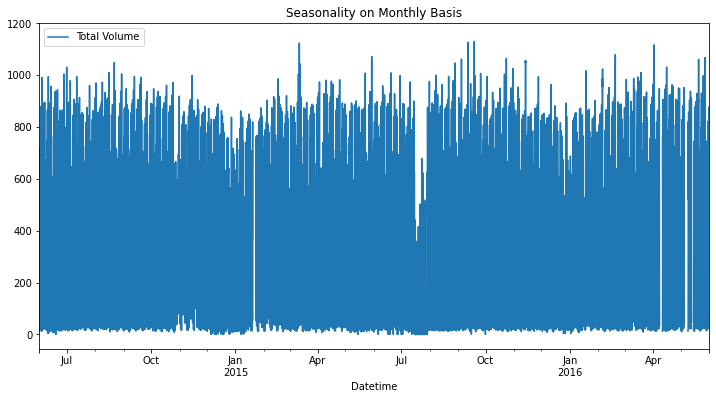

In [18]:
agg_traffic.plot(xlim=['2014-06-01 00:00:00','2016-06-01 00:00:00'], figsize=(12,6), title="Seasonality on Monthly Basis")

We can infer following points:
1. The traffic data rises during 12pm-6pm (peak hours) & falls to almost zero during midnight and morning.
2. Traffic is high during the weekdays, compared to the weekends.
3. There is less traffic in winters as compared to summers.

So we can say that the data is seasonal but has no trend. This will be helpful.

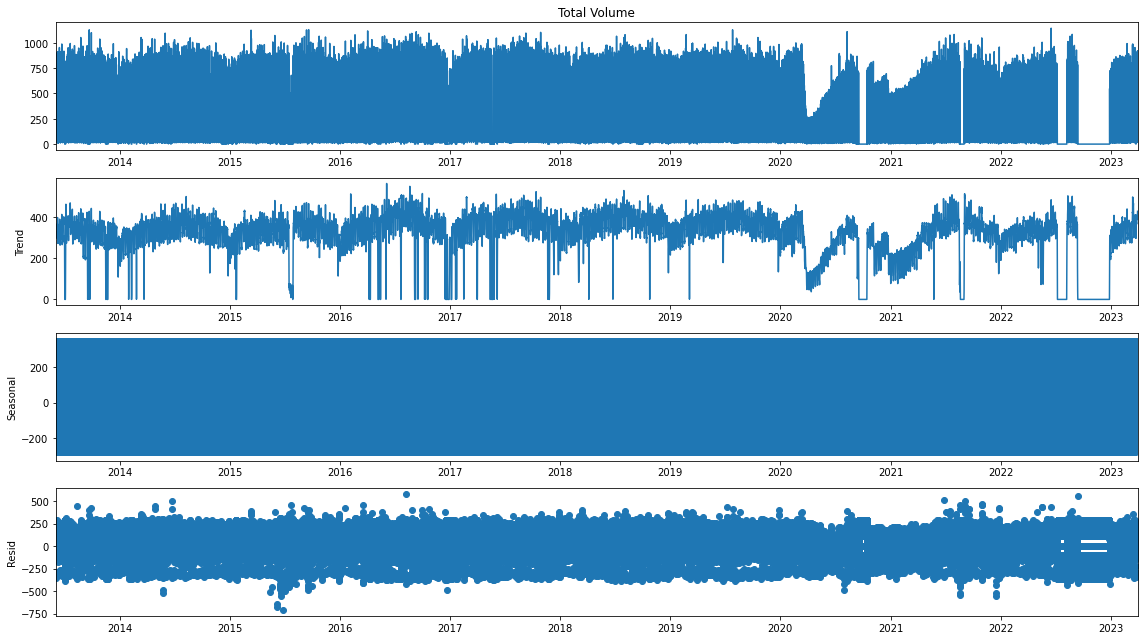

In [19]:
agg_copy = agg_traffic.copy().fillna(0)
result = seasonal_decompose(agg_copy['Total Volume'], model='additive', period=24)

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

There are a lot of missing values. So we have to figure out a way of handling it. We can see that post 2020 the missing values gaps are high. Also the COVID has had affects on traffic due to lockdown. So in this project, we will remove data post 2020 and will try to forecast in a non pandemic scenario.

In [20]:
df = agg_traffic.copy()

In [21]:
df = df[df.index < "2020-01-01 00:00:00"]

In [22]:
df

,Total Volume
Datetime,
2013-06-01 00:00:00,69.0
2013-06-01 01:00:00,33.0
2013-06-01 02:00:00,23.0
2013-06-01 03:00:00,24.0
2013-06-01 04:00:00,26.0
...,...
2019-12-31 19:00:00,194.0
2019-12-31 20:00:00,134.0
2019-12-31 21:00:00,71.0


<AxesSubplot:title={'center':'Road Traffic 2013-2019'}, xlabel='Datetime'>

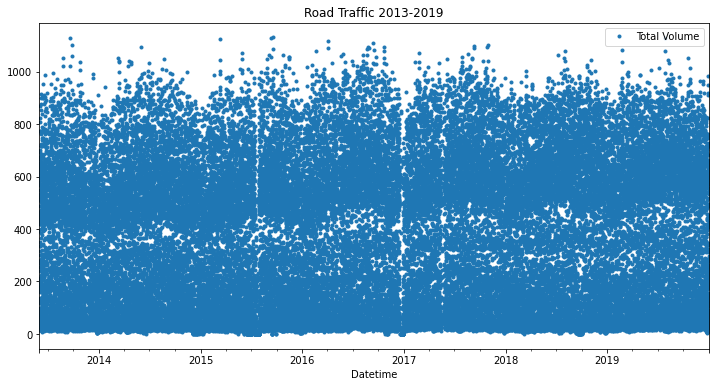

In [23]:
df.plot(style='.', figsize=(12,6),  title="Road Traffic 2013-2019")

In [24]:
unique_dates = np.unique(df[df['Total Volume'].isnull()].index.date)

max_consecutive_days = 0
current_consecutive_days = 0

for i in range(1, len(unique_dates)):
    if (unique_dates[i] - unique_dates[i - 1]).days == 1:
        current_consecutive_days += 1
    else:
        max_consecutive_days = max(max_consecutive_days, current_consecutive_days)
        current_consecutive_days = 0
        
print("Max number of consecutive missing days are: ",max_consecutive_days)

Max number of consecutive missing days are:  10


We have to fill max 10 days of data using some handling techniques. Since the data is huge, it shouldn't be a problem to use ffill or bfill or interpolation techniques. We'll try all and choose the best.

In [25]:
df.isnull().sum()

Total Volume    1808
dtype: int64

In [26]:
df[df['Total Volume']==0]

,Total Volume
Datetime,
2014-06-19 00:00:00,0.0
2014-12-04 23:00:00,0.0
2014-12-10 01:00:00,0.0
2014-12-11 03:00:00,0.0
2014-12-18 03:00:00,0.0
...,...
2016-12-28 15:00:00,0.0
2018-09-22 01:00:00,0.0
2018-09-25 00:00:00,0.0


#### ----> interpolation

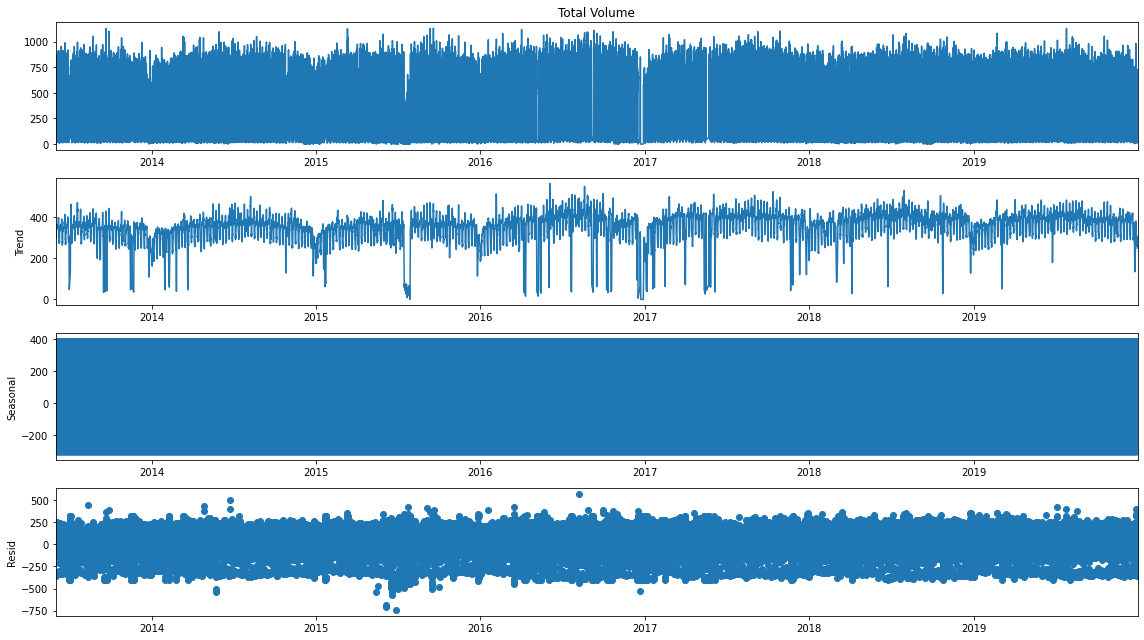

In [27]:
interpolation = df.copy()
interpolation['Total Volume'] = df['Total Volume'].interpolate(method='linear')
result = seasonal_decompose(interpolation['Total Volume'], model='additive', period=24)

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

#### ----> mean imputation

In [28]:
df_mean = df.copy()

weekly_daily_hourly_means = df_mean.groupby([df_mean.index.week, df_mean.index.dayofweek, df_mean.index.hour])['Total Volume'].mean()
df_mean['Total Volume'] = df_mean.apply(lambda row: weekly_daily_hourly_means[(row.name.week, row.name.dayofweek, row.name.hour)] if pd.isna(row['Total Volume']) else row['Total Volume'], axis=1)
df_mean['Total Volume'] = df_mean.apply(lambda row: weekly_daily_hourly_means[(row.name.week, row.name.dayofweek, row.name.hour)] if row['Total Volume'] == 0 else row['Total Volume'], axis=1)

C:\Users\OMEN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
weekly_daily_hourly_means

Datetime  Datetime  Datetime
1         0         0            32.428571
                    1            26.285714
                    2            16.000000
                    3            16.142857
                    4            22.428571
                                   ...    
53        6         19          249.000000
                    20          168.000000
                    21          133.000000
                    22           71.000000
                    23           54.000000
Name: Total Volume, Length: 8904, dtype: float64

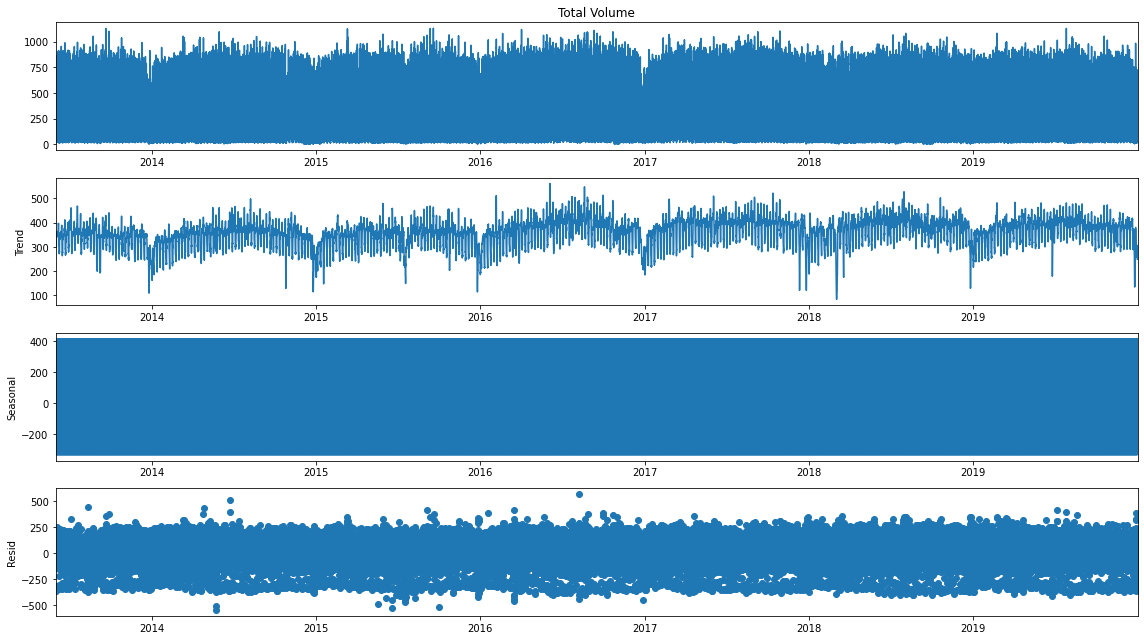

In [30]:
result = seasonal_decompose(df_mean['Total Volume'], model='additive', period=24)
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Seasonality on Daily Basis'}, xlabel='Datetime'>

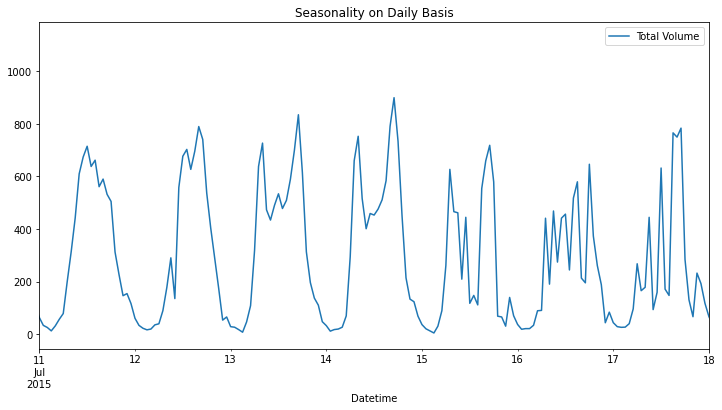

In [31]:
df_mean.plot(xlim=['2015-07-11 00:00:00','2015-07-18 00:00:00'], figsize=(12,6), title="Seasonality on Daily Basis")

<AxesSubplot:title={'center':'Seasonality on Weekly Basis'}, xlabel='Datetime'>

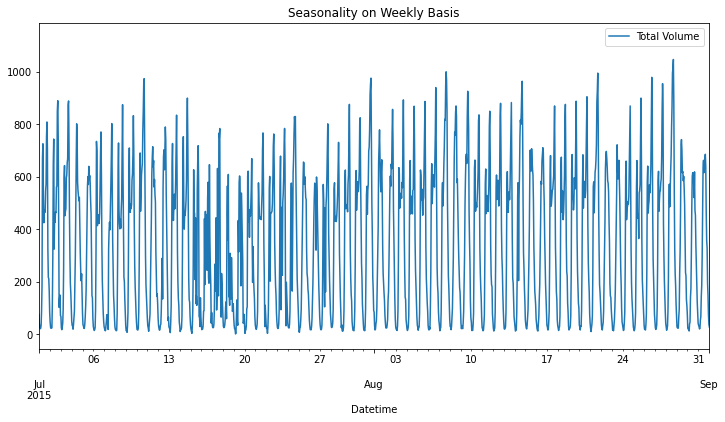

In [32]:
df_mean.plot(xlim=['2015-07-01 00:00:00','2015-09-01 00:00:00'], figsize=(12,6), title="Seasonality on Weekly Basis")

Since we already saw that the data is showing daily, weekly seasonality. I tried to impute the missing values with specific mean of that hour on that particular day for that particular week.

Missing values are imputed. The data look good as of now. Let's save it

In [33]:
clean_df = df_mean.copy()

In [34]:
clean_df['Year'] = clean_df.index.year
clean_df['Month'] = clean_df.index.month
clean_df['Day'] = clean_df.index.day
clean_df['DayOfWeek'] = clean_df.index.dayofweek
clean_df['Hour'] = clean_df.index.hour

Since, Month, DayOfWeek, Hour are cyclic in nature i.e. they repeat itself arfte a certain period of time. That's why we wont be encoding them in regular ways because that will lose information.

Since Monday is 0 and Sunday is 6, it will show that Sunday & Monday are quite different and apart. But that is not the case.

In [35]:
def CreateCyclicalFeature(data, column_name, num):
    data[f'sin_{column_name}'] = np.sin(2 * np.pi * data[column_name] / num)
    data[f'cos_{column_name}'] = np.cos(2 * np.pi * data[column_name] / num)
    data.drop(column_name, axis=1, inplace=True)
    return data

In [36]:
CreateCyclicalFeature(clean_df, 'Month', 12)
CreateCyclicalFeature(clean_df, 'DayOfWeek', 7)
CreateCyclicalFeature(clean_df, 'Hour', 24)

,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour
Datetime,,,,,,,,,
2013-06-01 00:00:00,69.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.000000,1.000000
2013-06-01 01:00:00,33.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.258819,0.965926
2013-06-01 02:00:00,23.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.500000,0.866025
2013-06-01 03:00:00,24.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.707107,0.707107
2013-06-01 04:00:00,26.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,194.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.965926,0.258819
2019-12-31 20:00:00,134.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.866025,0.500000
2019-12-31 21:00:00,71.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.707107,0.707107


In [37]:
clean_df

,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour
Datetime,,,,,,,,,
2013-06-01 00:00:00,69.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.000000,1.000000
2013-06-01 01:00:00,33.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.258819,0.965926
2013-06-01 02:00:00,23.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.500000,0.866025
2013-06-01 03:00:00,24.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.707107,0.707107
2013-06-01 04:00:00,26.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,194.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.965926,0.258819
2019-12-31 20:00:00,134.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.866025,0.500000
2019-12-31 21:00:00,71.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.707107,0.707107


In [38]:
clean_df.to_csv('dataset/processed/processed_traffic.csv')

### Weather EDA

In [39]:
weather.head()

,time,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
0,2013-06-01T00:00,11.7,78,0.0,0.0,0.0,1,18.5
1,2013-06-01T01:00,10.9,80,0.0,0.0,0.0,0,17.9
2,2013-06-01T02:00,10.2,81,0.0,0.0,0.0,0,17.6
3,2013-06-01T03:00,9.5,80,0.0,0.0,0.0,0,16.7
4,2013-06-01T04:00,8.9,79,0.0,0.0,0.0,0,16.1


In [40]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86184 entries, 0 to 86183
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 86184 non-null  object 
 1   temperature_2m       86184 non-null  float64
 2   relativehumidity_2m  86184 non-null  int64  
 3   precipitation        86184 non-null  float64
 4   rain                 86184 non-null  float64
 5   snowfall             86184 non-null  float64
 6   weathercode          86184 non-null  int64  
 7   windspeed_10m        86184 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.3+ MB


In [41]:
weather.isnull().sum()

time                   0
temperature_2m         0
relativehumidity_2m    0
precipitation          0
rain                   0
snowfall               0
weathercode            0
windspeed_10m          0
dtype: int64

In [42]:
weather['time'] = pd.to_datetime(weather['time'])
weather.rename(columns={'time': 'Datetime'}, inplace=True)
weather = weather.set_index('Datetime')

In [43]:
weather_df = weather[weather.index < "01-01-20 00:00:00"]

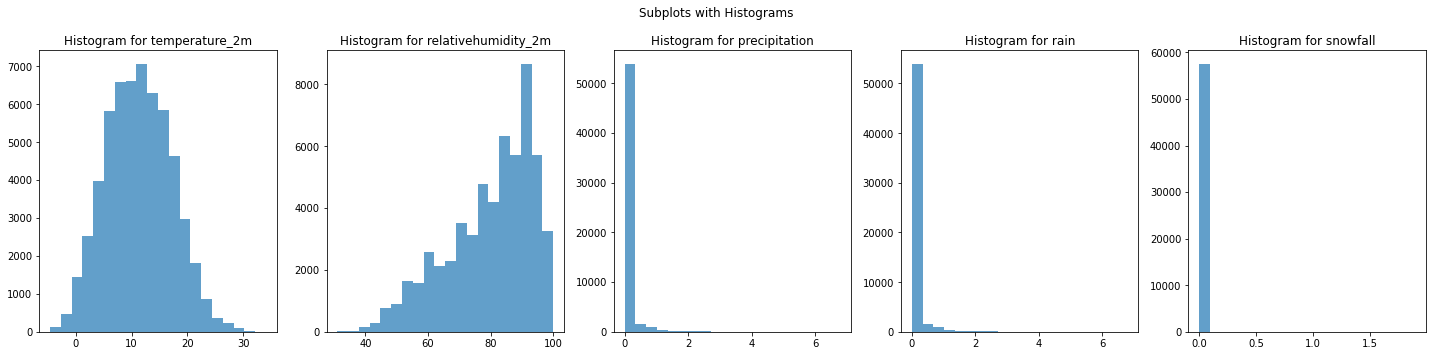

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, column_name in enumerate(weather_df.columns[:5]):
    axs[i].hist(weather_df[column_name], bins=20, alpha=0.7)
    axs[i].set_title(f'Histogram for {column_name}')

fig.suptitle('Subplots with Histograms')
plt.tight_layout()
plt.show()

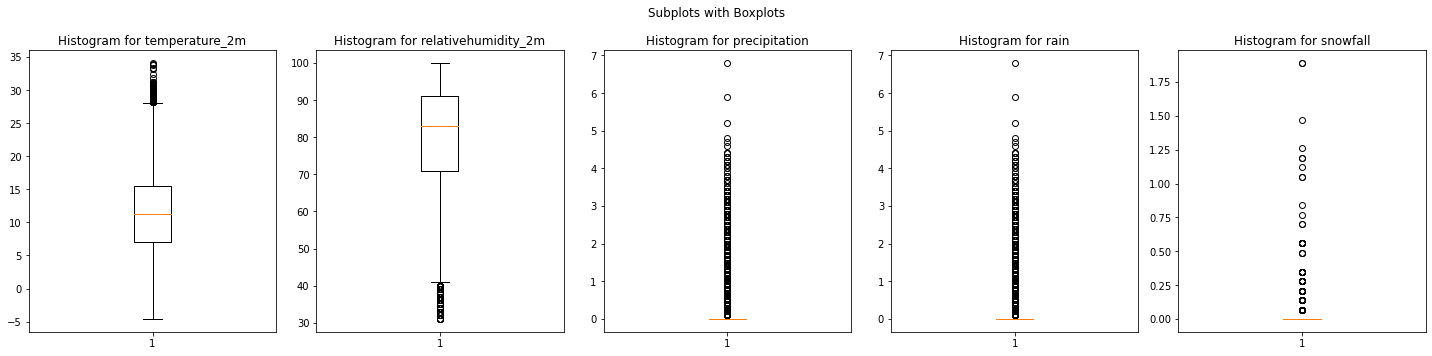

In [45]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, column_name in enumerate(weather_df.columns[:5]):
    axs[i].boxplot(weather_df[column_name])
    axs[i].set_title(f'Histogram for {column_name}')

fig.suptitle('Subplots with Boxplots')
plt.tight_layout()
plt.show()

Although there are a lot of outliers as shown above, but we won't be removing it because these are important. These changes in weather data should be kept in mind as the outliers give us great information.

In [46]:
weather_df.to_csv('dataset/processed/processed_weather.csv')

### Merging both data

In [58]:
df_traffic = pd.read_csv('dataset/processed/processed_traffic.csv')
df_weather = pd.read_csv('dataset/processed/processed_weather.csv')

print(df_traffic.shape, df_weather.shape)

(57720, 10) (57720, 8)


In [59]:
df_traffic.head()

,Datetime,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour
0,2013-06-01 00:00:00,69.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.000000,1.000000
1,2013-06-01 01:00:00,33.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.258819,0.965926
2,2013-06-01 02:00:00,23.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.500000,0.866025
3,2013-06-01 03:00:00,24.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.707107,0.707107
4,2013-06-01 04:00:00,26.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.866025,0.500000


In [60]:
df_weather.head()

,Datetime,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
0,2013-06-01 00:00:00,11.7,78,0.0,0.0,0.0,1,18.5
1,2013-06-01 01:00:00,10.9,80,0.0,0.0,0.0,0,17.9
2,2013-06-01 02:00:00,10.2,81,0.0,0.0,0.0,0,17.6
3,2013-06-01 03:00:00,9.5,80,0.0,0.0,0.0,0,16.7
4,2013-06-01 04:00:00,8.9,79,0.0,0.0,0.0,0,16.1


In [61]:
data = pd.merge(df_traffic, df_weather, on='Datetime')
data = data.set_index('Datetime')

In [62]:
data

,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
Datetime,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,69.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.000000,1.000000,11.7,78,0.0,0.0,0.0,1,18.5
2013-06-01 01:00:00,33.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.258819,0.965926,10.9,80,0.0,0.0,0.0,0,17.9
2013-06-01 02:00:00,23.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.500000,0.866025,10.2,81,0.0,0.0,0.0,0,17.6
2013-06-01 03:00:00,24.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.707107,0.707107,9.5,80,0.0,0.0,0.0,0,16.7
2013-06-01 04:00:00,26.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.866025,0.500000,8.9,79,0.0,0.0,0.0,0,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,194.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.965926,0.258819,7.2,97,0.0,0.0,0.0,3,14.6
2019-12-31 20:00:00,134.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.866025,0.500000,7.0,97,0.0,0.0,0.0,3,15.0
2019-12-31 21:00:00,71.0,2019,31,-2.449294e-16,1.0,0.781831,0.623490,-0.707107,0.707107,6.6,97,0.0,0.0,0.0,2,14.8


In [63]:
data.to_csv('dataset/processed/traffic-weather-data.csv')